In [1]:
import sys
sys.path.insert(0, '../Utilities')

from tqdm import tqdm
import numpy as np
from collections import defaultdict

import networkx as nx

import hypergraphx as hx
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.representations.projections import bipartite_projection
from hypergraphx.generation.random import random_hypergraph

from utilities_fibration import *
from trajectories_kuramoto_hoi import *
from find_sync_clusters_from_trajectories import *

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # use serif font
    "text.latex.preamble": r"\usepackage{lmodern}",  # match LaTeX document font
})

In [2]:
# Random hypergraph assigning the number of nodes and edges for each order

N = 520
hpg = random_hypergraph(N, {2: 314, 3: 112})


In [3]:
# We consider only the largest connected component
sub_hpg = hpg.subhypergraph_largest_component()

In [4]:
# Normalize the edge list by removing holes in the sequences
edge_list_sc_filtered_holes = [list(x) for x in sub_hpg.get_edges()]
edge_list = normalize_sequence(edge_list_sc_filtered_holes)[0]
len(edge_list)

406

In [5]:
# Compute its bipartite projection
edge_list_sc_filtered = Hypergraph(edge_list)
bsc_tot = bipartite_projection(edge_list_sc_filtered)
bsc = bsc_tot[0]
bhg_dict = bsc_tot[1]
color_dict = bipartite.color(bsc)

In [6]:
# Compute fibration coloring on the multigraph

result_hg = kameicock_coloring(bsc, color_dict)

In [7]:
# extract colors only of node in layer 0
node_cluster_hg = {k: v for k, v in result_hg.items() if k.startswith('N')}
cl_hg = []

for val in set(node_cluster_hg.values()):
    cl_hg.append([k for k, v in node_cluster_hg.items() if v == val])

edge_name_dict = bhg_dict
edge_col_dict = result_hg

dic = {v: edge_col_dict[k] for k, v in edge_name_dict.items()}

In [8]:
list_c = cl_hg
print(list_c)

# Transform the list of the node cluster substituting with the original names
clusters = [[edge_name_dict[item] for item in sublist] for sublist in list_c] 

[['N163'], ['N10'], ['N179'], ['N161'], ['N126'], ['N102'], ['N55', 'N120'], ['N263'], ['N4'], ['N280'], ['N213'], ['N154'], ['N275'], ['N92'], ['N69'], ['N38'], ['N106', 'N323'], ['N214'], ['N233'], ['N22'], ['N384'], ['N260'], ['N212'], ['N362'], ['N312'], ['N145'], ['N204'], ['N309'], ['N13'], ['N221'], ['N276'], ['N228'], ['N5'], ['N43'], ['N74'], ['N153'], ['N259'], ['N253'], ['N70'], ['N357'], ['N288'], ['N301'], ['N229'], ['N155'], ['N297'], ['N130'], ['N87'], ['N334'], ['N237'], ['N255'], ['N33'], ['N116'], ['N146'], ['N375'], ['N18'], ['N243'], ['N75'], ['N101'], ['N232'], ['N405'], ['N46'], ['N268'], ['N258'], ['N6', 'N134'], ['N216'], ['N182'], ['N112'], ['N296'], ['N48'], ['N283'], ['N77'], ['N363'], ['N208'], ['N381'], ['N86'], ['N98'], ['N238'], ['N298'], ['N61'], ['N333'], ['N30'], ['N346'], ['N378'], ['N240'], ['N285'], ['N62'], ['N99'], ['N49'], ['N16'], ['N40'], ['N382'], ['N139'], ['N193'], ['N330'], ['N337'], ['N374'], ['N358'], ['N393'], ['N109'], ['N36'], ['N389',

In [9]:
node_col_dic = np.array([c for key, c in dic.items() if  isinstance(key, int)])

In [10]:
# Ratio nodes/cluster
nodes_list = edge_list_sc_filtered.get_nodes()
len(nodes_list)/len(clusters)

1.0354430379746835

In [11]:
# Compute trajectories on the multigraph for the Kuramoto model with frustration parameters
# Fix initial conditions

N = len(nodes_list)

omega = np.zeros(N)

sigma2 = 0.2
sigma3 = 0.6

IC = np.ones(N)

In [12]:
# Integration times and steps
T_max = 1000
step = 1
repetition = T_max/step

In [13]:
# Simulate
model = KuramotoHypergraph(edge_list, omega, [sigma2,sigma3], [np.pi/6, np.pi/6, np.pi/6])
t, theta_history = model.simulate(T=repetition, dt=step, initial_conditions=IC)

In [14]:
# Compute max diff in each cluster
cluster_states = []
for cluster in clusters:
    arrays = theta_history[:,[i for i in cluster]]
    min_vals = np.min(arrays, axis=1) 
    max_vals = np.max(arrays, axis=1) 
    cluster_states.append(abs(max_vals - min_vals))
cluster_states = np.array(cluster_states) 

In [15]:
# CLusters with more than one nodes
c = [e for e in clusters if len(e) > 1]
num_nontrivial_clusters = len(c)
print(f'Number of non trivial clusters: {num_nontrivial_clusters}')
c

Number of non trivial clusters: 14


[[74, 351],
 [177, 154],
 [44, 244],
 [227, 291],
 [63, 64],
 [195, 61],
 [37, 118],
 [69, 367],
 [7, 293],
 [310, 380],
 [42, 116],
 [225, 45],
 [274, 247],
 [19, 141]]

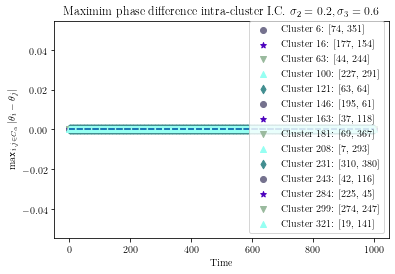

In [16]:
# Plot the synchronization error

cluster_colors = sns.color_palette(cc.glasbey_cool[6:], num_nontrivial_clusters)
markers = ['o', '*', "v", "^", "d", "s"]

plt.figsize=(15, 30)

# Plot the synchronization error

i = 0
for cluster_i, max_diff in enumerate(cluster_states):
        if len(clusters[cluster_i]) > 1:
                plt.scatter(t, max_diff, marker=markers[i%5], color=cluster_colors[i%5], label=f'Cluster {cluster_i}: {clusters[cluster_i]}')
        #gammas[cluster_i]
                plt.hlines(y = 0, xmin = t[0], xmax = t[-1], color=cluster_colors[i], linestyle = '--')
                i += 1

                plt.xlabel('Time')
                label = r'$\max_{i,j \in C_\alpha} \vert \theta_i - \theta_j \vert$'
                plt.ylabel(label)
                plt.legend(loc='lower right', ncol=1)
                plt.tick_params(axis='both', which='major')
                plt.title(f'Maximim phase difference intra-cluster I.C. $\sigma_2 = {sigma2}, \sigma_3 = {sigma3}$')
                plt.grid()

Cluster [74, 351]: 1.0
Cluster [177, 154]: 1.0
Cluster [44, 244]: 1.0
Cluster [227, 291]: 1.0
Cluster [63, 64]: 1.0
Cluster [195, 61]: 1.0
Cluster [37, 118]: 1.0
Cluster [69, 367]: 1.0
Cluster [7, 293]: 1.0
Cluster [310, 380]: 1.0
Cluster [42, 116]: 1.0
Cluster [225, 45]: 1.0
Cluster [274, 247]: 1.0
Cluster [19, 141]: 1.0
Global parameter: 0.2965594971684365


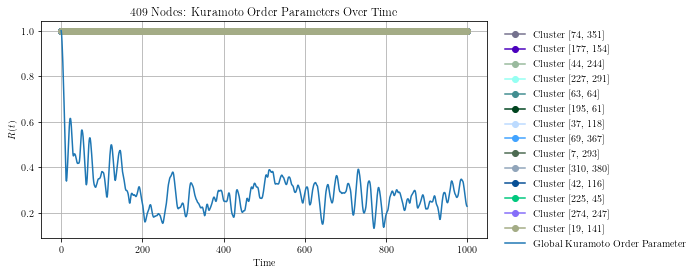

In [17]:
# Plot the Kuramoto order parameter over time for each cluster and global

plt.figure(figsize=(8, 4))

i = 0
# Example usage (assuming theta is already defined):
for idx, cluster in enumerate(c):
    arrays = theta_history[:,[i for i in cluster]]
    R = kuramoto_order_parameter_over_time(arrays)
    print(f'Cluster {cluster}: {np.sum(R) / repetition}')

    #plt.plot(R, marker=markers[i%5], color=cluster_colors[i%5], label=f'Cluster {cluster}')
    if idx == len(c)-1:
        plt.plot(R, marker=markers[0], color='#a4ac86', label=f'Cluster {cluster}')
    else:
        plt.plot(R, marker=markers[0], color=cluster_colors[idx], label=f'Cluster {cluster}')

    i += 1

arrays = theta_history[:,]
R_tot = kuramoto_order_parameter_over_time(arrays)
plt.plot(R_tot, label='Global Kuramoto Order Parameter')
print(f'Global parameter: {np.sum(R_tot) / repetition}')


plt.xlabel('Time')
plt.ylabel('$R(t)$')
plt.title(f'{len(nodes_list)} Nodes: Kuramoto Order Parameters Over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
#plt.tight_layout()

#plt.savefig(f'Images/Frustration_results/Order_parameters_time_{len(nodes_list)}_nodes', dpi=800, bbox_inches='tight', transparent=True)


***Detection of the synchronized nodes***
 
Apply the function that, given the trajectories and the nodes grouped by degree, finds the non trivial synchronized clusters (In the paper is Algorithm 2).
To apply the algorithm, I write for each node the degree sequence for all the edge orders appearing in the hypergraph.
Then I categorize the nodes having the same degree sequence.

In [18]:
rk = max(len(e) for e in edge_list)
rk

3

In [19]:
nodes_deg_seq = {n: [edge_list_sc_filtered.degree(n, order = ord) for ord in range(1,rk+1)] for n in edge_list_sc_filtered.get_nodes()}

{93: [4, 1, 0],
 400: [4, 2, 0],
 22: [3, 0, 0],
 41: [3, 1, 0],
 210: [2, 1, 0],
 302: [4, 1, 0],
 44: [1, 0, 0],
 195: [1, 1, 0],
 218: [4, 1, 0],
 254: [4, 0, 0],
 105: [2, 0, 0],
 265: [2, 0, 0],
 261: [5, 0, 0],
 333: [1, 1, 0],
 119: [2, 0, 0],
 192: [1, 1, 0],
 343: [2, 4, 0],
 366: [1, 0, 0],
 138: [3, 0, 0],
 21: [1, 1, 0],
 232: [2, 0, 0],
 243: [1, 1, 0],
 35: [3, 1, 0],
 276: [1, 0, 0],
 315: [3, 0, 0],
 405: [3, 0, 0],
 53: [3, 0, 0],
 128: [1, 0, 0],
 362: [1, 2, 0],
 404: [2, 1, 0],
 264: [4, 1, 0],
 316: [3, 0, 0],
 14: [1, 0, 0],
 204: [3, 1, 0],
 132: [2, 2, 0],
 308: [3, 0, 0],
 66: [3, 0, 0],
 115: [2, 0, 0],
 5: [1, 2, 0],
 91: [4, 3, 0],
 11: [2, 1, 0],
 163: [1, 0, 0],
 0: [1, 2, 0],
 283: [2, 2, 0],
 142: [5, 0, 0],
 203: [5, 1, 0],
 324: [2, 0, 0],
 389: [4, 0, 0],
 346: [3, 0, 0],
 408: [1, 0, 0],
 326: [1, 1, 0],
 349: [2, 1, 0],
 193: [4, 0, 0],
 199: [2, 1, 0],
 63: [2, 0, 0],
 74: [1, 0, 0],
 46: [1, 1, 0],
 106: [1, 0, 0],
 56: [2, 3, 0],
 78: [2, 0, 0],


In [20]:
degree_seq_to_nodes = defaultdict(list)
for node, degrees in nodes_deg_seq.items():
    degree_seq_to_nodes[tuple(degrees)].append(node)

# Convert defaultdict to regular dict if needed
dict_nodes = dict(degree_seq_to_nodes)
print(dict_nodes)

{(4, 1, 0): [93, 302, 218, 264, 155], (4, 2, 0): [400, 165, 67], (3, 0, 0): [22, 138, 315, 405, 53, 316, 308, 66, 346, 321, 28, 29, 260, 160, 269, 255, 371, 318, 4, 231, 233, 161, 379, 301, 328, 104, 279, 139], (3, 1, 0): [41, 35, 204, 289, 186, 280, 384, 147, 117], (2, 1, 0): [210, 404, 11, 349, 199, 150, 235, 399, 127, 79, 197, 167, 140, 51, 322, 202, 234, 226, 34, 288, 171, 107, 16, 222, 12, 341, 296, 258, 344, 94], (1, 0, 0): [44, 366, 276, 128, 14, 163, 408, 74, 106, 110, 225, 190, 229, 312, 396, 392, 177, 57, 351, 62, 55, 19, 84, 336, 244, 179, 27, 1, 242, 141, 249, 8, 136, 248, 403, 372, 158, 292, 72, 58, 175, 32, 36, 39, 48, 237, 76, 239, 206, 353, 309, 216, 30, 251, 87, 125, 214, 386, 359, 83, 374, 397, 267, 82, 201, 37, 97, 77, 118, 50, 89, 96, 285, 149, 152, 122, 45, 120, 154, 270, 188, 191, 159], (1, 1, 0): [195, 333, 192, 21, 243, 326, 46, 354, 43, 281, 65, 266, 274, 253, 334, 347, 198, 332, 61, 252, 151, 24, 23, 323, 145, 71, 383, 358, 182, 156, 173, 194, 157, 385, 259, 2

In [21]:
#Apply the function that, given the trajectories and the nodes grouped by degree, finds the non trivial synchronized clusters

synchronized_clusters_seq = find_synchronized_clusters_from_pairs(
    theta_history=theta_history,
    nodes_by_degree=dict_nodes,
    #H=H,  # your hypergraph object with .get_neighbors()
    tol=1e-6,
    #max_subset_size=8,
    phase_tol=0.5,
    n_check_times=5
)

print(synchronized_clusters_seq)


  0%|          | 0/25 [00:00<?, ?it/s]

Degree sequence: (4, 1, 0) (5 nodes)


  4%|▍         | 1/25 [00:01<00:33,  1.39s/it]

Degree sequence: (4, 2, 0) (3 nodes)
Degree sequence: (3, 0, 0) (28 nodes)


 12%|█▏        | 3/25 [00:03<00:27,  1.25s/it]

Degree sequence: (3, 1, 0) (9 nodes)


 20%|██        | 5/25 [00:04<00:13,  1.47it/s]

Degree sequence: (2, 1, 0) (30 nodes)
Degree sequence: (1, 0, 0) (83 nodes)


 24%|██▍       | 6/25 [00:11<00:53,  2.79s/it]

Degree sequence: (1, 1, 0) (74 nodes)


 36%|███▌      | 9/25 [00:18<00:35,  2.22s/it]

Degree sequence: (4, 0, 0) (7 nodes)
Degree sequence: (2, 0, 0) (47 nodes)
Degree sequence: (5, 0, 0) (3 nodes)
Degree sequence: (2, 4, 0) (2 nodes)
Degree sequence: (1, 2, 0) (21 nodes)
Degree sequence: (2, 2, 0) (13 nodes)
Degree sequence: (4, 3, 0) (2 nodes)
Degree sequence: (2, 3, 0) (3 nodes)
Degree sequence: (3, 2, 0) (4 nodes)
Degree sequence: (1, 3, 0) (2 nodes)
Degree sequence: (0, 1, 0) (51 nodes)


100%|██████████| 25/25 [00:22<00:00,  1.12it/s]

Degree sequence: (0, 2, 0) (16 nodes)
[[44, 244], [74, 351], [45, 225], [154, 177], [19, 141], [37, 118], [61, 195], [247, 274], [63, 64], [69, 367], [227, 291], [42, 116], [310, 380], [7, 293]]


In [23]:
# Check if nontrivial fibres coincide with detected synchronized nodes

set1 = set(frozenset(inner) for inner in c)
set2 = set(frozenset(inner) for inner in synchronized_clusters_seq)

print(set1.difference(set2))


print(c)
print(synchronized_clusters_seq)

set()
[[74, 351], [177, 154], [44, 244], [227, 291], [63, 64], [195, 61], [37, 118], [69, 367], [7, 293], [310, 380], [42, 116], [225, 45], [274, 247], [19, 141]]
[[44, 244], [74, 351], [45, 225], [154, 177], [19, 141], [37, 118], [61, 195], [247, 274], [63, 64], [69, 367], [227, 291], [42, 116], [310, 380], [7, 293]]
